In [1]:
from pathlib import Path
from util import NUMBER_REGEX
import numpy as np

simon_dir = "sim/simon_simulations_20220721_torques/"
simon_path = Path(simon_dir)

In [28]:
sims = {}

c = 0
def p(*args, **kwargs):
    global c
    if c < 10:
        print(*args, **kwargs)
        c += 1

for sim_path in (i for j in zip(simon_path.glob("iopf_sim_DRAG*"), simon_path.glob("iopf_sim_torque*")) for i in j):
    label = sim_path.name
    slabel = label.split("_")
    drag_coefficient = int(slabel[slabel.index('DRAG')+1][0])
    n_particles = int(slabel[slabel.index('N')+1])
    seed = int(slabel[-1])
    torque = int("torque" in label)

    output_path = sim_path / "output.txt"
    with open(output_path, "r") as output_file:
        _t = 0
        _sysT = 0
        L = []
        for line in output_file:
            if line.startswith("t = "):
                t, N, sysT, *_ = map(float, NUMBER_REGEX.findall(line))

                if sysT > _sysT:
                    dt = t - _t
                    dsysT = sysT - _sysT
                    L.append((N, dt/dsysT))

                _t = t
                _sysT = sysT
    
    sims[label] = {
        "label": label,
        "drag_coefficient": drag_coefficient,
        "n_particles": n_particles,
        "seed": seed,
        "path": sim_path,
        "runtimes": np.array(L),
        "torque": torque
    }

    print(f"{label} {drag_coefficient=} {n_particles=} {seed=} {torque=}")

iopf_sim_DRAG_1.0_N_100_29381 drag_coefficient=1 n_particles=100 seed=29381 torque=0
iopf_sim_torque_DRAG_1.0_N_100_29381 drag_coefficient=1 n_particles=100 seed=29381 torque=1
iopf_sim_DRAG_1.0_N_100_47220 drag_coefficient=1 n_particles=100 seed=47220 torque=0
iopf_sim_torque_DRAG_1.0_N_100_47220 drag_coefficient=1 n_particles=100 seed=47220 torque=1
iopf_sim_DRAG_1.0_N_100_61392 drag_coefficient=1 n_particles=100 seed=61392 torque=0
iopf_sim_torque_DRAG_1.0_N_100_61392 drag_coefficient=1 n_particles=100 seed=61392 torque=1
iopf_sim_DRAG_1.0_N_100_92718 drag_coefficient=1 n_particles=100 seed=92718 torque=0
iopf_sim_torque_DRAG_1.0_N_100_92718 drag_coefficient=1 n_particles=100 seed=92718 torque=1


In [29]:
from h5py import File
import gc

for obj in gc.get_objects():   # Browse through ALL objects
    if isinstance(obj, File):   # Just HDF5 files
        try:
            obj.close()
        except:
            pass # Was already closed

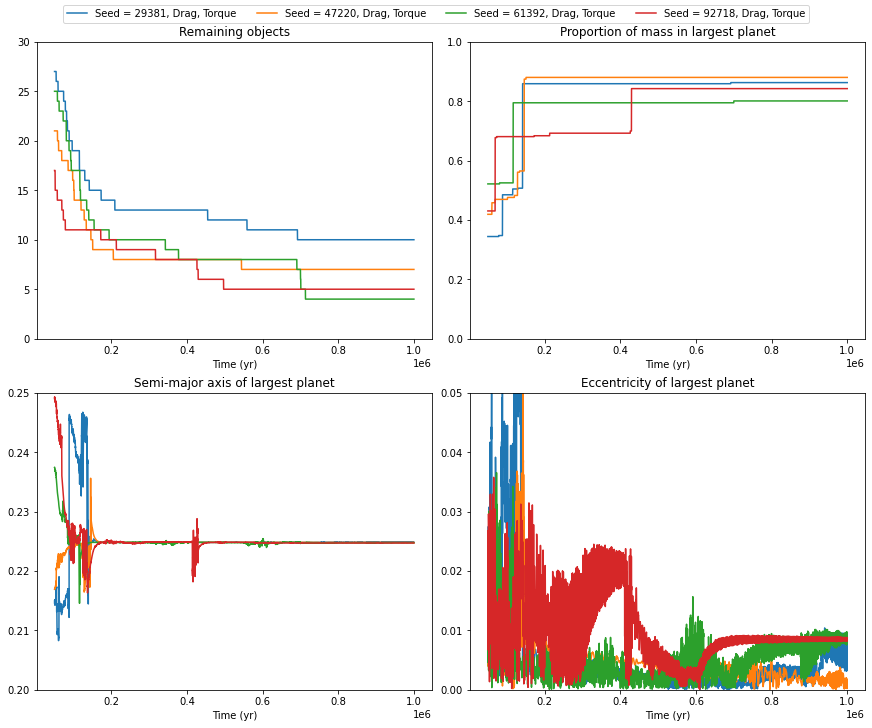

In [26]:
import matplotlib.pyplot as plt
import h5py
import util

def make_label(v):
    t = "Torque" if v["torque"] else "No Torque"

    if v["drag_coefficient"] == 1:
        return f"Seed = {v['seed']}, Drag, {t}"
    if v["drag_coefficient"] == 0:
        return f"Seed = {v['seed']}, No Drag, {t}"

def plot_remaining_over_time(ax, steps, **kwargs):
    remaining = []
    time = []
    for step in steps:
        time.extend(step["time"])
        remaining.extend(np.sum(~np.isnan(step["mass"]), axis=1) - 1)

    ax.plot(time, np.array(remaining), **kwargs)

    # ax.legend()
    ax.set_title(rf"Remaining objects")
    ax.set_xlabel("Time (yr)")

    ax.set_ylim(0, 30)

# def plot_energy_over_time(ax, steps, **kwargs):
#     E = []
#     time = []
#     for step in steps:
#         time.extend(step["time"])
#         E.extend(step["energy"])

#     ax.plot(time, np.array(E), **kwargs)

#     # ax.legend()
#     ax.set_xlim(0, 1000000)
#     ax.set_title(rf"Energy")
#     ax.set_xlabel("Time (yr)")

#     ax.set_yticklabels([])

def plot_top_mass_over_time(ax, steps, **kwargs):
    mt = []
    time = []
    for step in steps:
        time.extend(step["time"])
        ms = step["mass"][:, 1:]
        mt.extend(np.array(step["mass"])[np.arange(ms.shape[0]), 1+np.argmax(ms, axis=1)] / np.nansum(ms, axis=1))

    ax.plot(time, np.array(mt), **kwargs)

    # ax.legend()
    ax.set_title(rf"Proportion of mass in largest planet")
    ax.set_xlabel("Time (yr)")
    ax.set_ylim(0, 1.0)

def plot_top_mass_a_over_time(ax, steps, **kwargs):
    mt = []
    time = []
    for step in steps:
        time.extend(step["time"])
        ms = step["mass"][:, 1:]
        mt.extend(np.array(step["a"])[np.arange(ms.shape[0]), 1+np.argmax(ms, axis=1)])

    ax.plot(time, np.array(mt), **kwargs)

    # ax.legend()
    ax.set_title(rf"Semi-major axis of largest planet")
    ax.set_xlabel("Time (yr)")
    ax.set_ylim(0.20, 0.25)

def plot_top_mass_e_over_time(ax, steps, **kwargs):
    mt = []
    time = []
    for step in steps:
        time.extend(step["time"])
        ms = step["mass"][:, 1:]
        mt.extend(np.array(step["ecc"])[np.arange(ms.shape[0]), 1+np.argmax(ms, axis=1)])

    ax.plot(time, np.array(mt), **kwargs)

    # ax.legend()
    ax.set_title(rf"Eccentricity of largest planet")
    ax.set_xlabel("Time (yr)")
    ax.set_ylim(0.0, 0.05)

def plot_over_time(ax, steps, column, mathtext, **kwargs):
    std_e = []
    mean_e = []
    # min_e = []
    # max_e = []

    time = []
    for step in steps:
        time.extend(step["time"])
        data = step[column][:, 1:]
        m = step["mass"][:, 1:]
    
        wa = np.nansum(data * m, axis=1) / np.nansum(m, axis=1)
        ws = np.sqrt(np.nansum((data - wa[:, np.newaxis])**2. * m, axis=1) / np.nansum(m, axis=1))

        mean_e.extend(wa)
        std_e.extend(ws)

        # min_e.extend(np.percentile(data, 25, axis=1))
        # max_e.extend(np.percentile(data, 75, axis=1))

    ax.plot(time, np.array(mean_e), **kwargs)
    ax.fill_between(time, np.array(mean_e) - np.array(std_e), np.array(mean_e) + np.array(std_e), alpha=0.1, ec="face")
    # ax.fill_between(time, np.array(min_e), np.array(max_e), alpha=0.1, ec="face")

    # ax.legend()
    ax.set_title(rf"$\mathrm{{weighted mean}}({mathtext}) \pm \mathrm{{std}}({mathtext})$")
    ax.set_xlabel("Time (yr)")
    

def plot_std_over_time(ax, steps, column, mathtext, **kwargs):
    std_e = []
    time = []
    for step in steps:
        time.extend(step["time"])
        data = step[column][:, 1:]
        std_e.extend(np.nanstd(data, axis=1))
    ax.plot(time, np.array(std_e), **kwargs)

    # ax.legend()
    ax.set_xlim(0, 1000000)
    ax.set_title(rf"$\mathrm{{std}}({mathtext})$")
    ax.set_xlabel("Time (yr)")


def double_plot(axs, steps, column, mathtext, **kwargs):
    plot_over_time(axs[0], steps, column, mathtext, **kwargs)
    plot_std_over_time(axs[1], steps, column, mathtext, **kwargs)


fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

for k, v in sorted(sims.items()):
    if v["n_particles"] > 50:
        f = h5py.File(v["path"] / f"mercurius_data_reb_{v['seed']}.h5", "r")
        sorted_steps = util.sorted_steps(f)
        plot_remaining_over_time(axs[0][0], sorted_steps, label=make_label(v))
        plot_top_mass_over_time(axs[0][1], sorted_steps, label=make_label(v))
        plot_top_mass_a_over_time(axs[1][0], sorted_steps, label=make_label(v))
        plot_top_mass_e_over_time(axs[1][1], sorted_steps, label=make_label(v))

        # double_plot(axs[1], sorted_steps, "a", "a", label=make_label(v))
        # double_plot(axs[2], sorted_steps, "ecc", "e", label=make_label(v))
        # double_plot(axs[3], sorted_steps, "inc", "i", label=make_label(v))
        f.close()

fig.suptitle("Time evolution of orbits (N=100)", alpha=0)

plt.figlegend(handles=axs[0][0].get_lines(), ncol=4, loc="upper center", frameon=True)
